### Метрики качества классификации
Сегодня мы научимся использовать различные метрики для сравнения качества моделей.
Для начала загрузим данные с предыдущей домашей задачи с небольшим `сюрпризом`. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Загрузим данные
# # Your code here
data = pd.read_csv('proccessed_train.csv')

In [3]:
import pandas as pd

# Проверяем наличие нужного столбца
if 'HasDetections' not in data.columns:
    raise ValueError("Колонка 'HasDetections' не найдена в датасете. Проверьте структуру файла.")

# Посмотрим на начальное распределение классов
print("Изначальное распределение классов:")
print(data['HasDetections'].value_counts())

# Параметры для создания дисбаланса
target_class = 1  # Класс, который будем уменьшать
desired_ratio = 0.6  # Оставить только 10% записей target_class

# Разделяем данные на два класса
data_class_0 = data[data['HasDetections'] == 0]  # Все записи класса 0
data_class_1 = data[data['HasDetections'] == 1]  # Все записи класса 1

# Создаём дисбаланс: уменьшаем target_class
if target_class == 1:
    data_class_1 = data_class_1.sample(frac=desired_ratio, random_state=42)  # Оставляем 10% класса 1
else:
    data_class_0 = data_class_0.sample(frac=desired_ratio, random_state=42)  # Оставляем 10% класса 0

# Объединяем обратно
data_unbalanced = pd.concat([data_class_0, data_class_1])

# Проверяем новое распределение
print("Новое распределение классов:")
print(data_unbalanced['HasDetections'].value_counts())


Изначальное распределение классов:
HasDetections
1    100059
0     99940
Name: count, dtype: int64
Новое распределение классов:
HasDetections
0    99940
1    60035
Name: count, dtype: int64


Один из гномов нарушил баланс классов в данных. Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [4]:
# Your code here2
data = data_unbalanced

In [5]:
data['HasDetections'].value_counts()

HasDetections
0    99940
1    60035
Name: count, dtype: int64

-- *Классы несбалансированы*

Произведем процедуру отложенной выборки

In [6]:
# Разделим данные на X (признаки) и y (целевая переменная)
X = data.drop(columns='HasDetections')
y = data['HasDetections']

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()),
                 ('LR',LogisticRegression(penalty='l2',C=0.01))
                 ])
pipe.fit(x_train,y_train)
y_pred = pipe.predict(x_test)
pipe.score(x_test,y_test)

0.6757618377871543

Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confusion matrix** (матрица ошибок).
Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

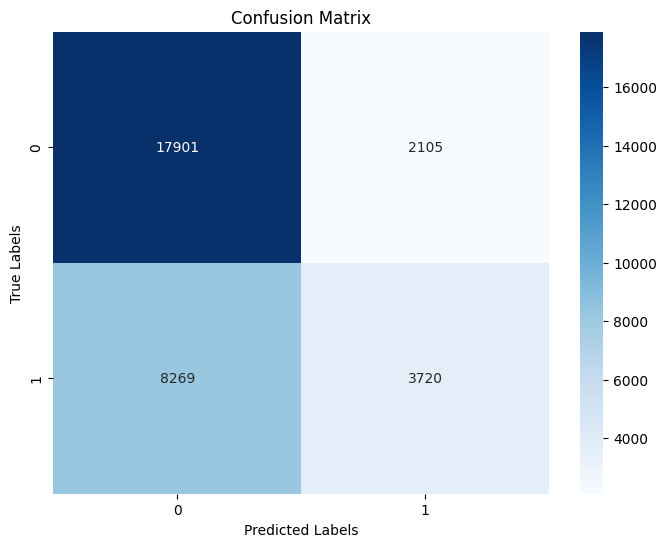

[[17901  2105]
 [ 8269  3720]]


In [8]:
# Подсчитайте матрицу ошибок вручную
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(cm)


# Сравните с результатами sklearn
# Your code here

**Задание 2.2.**
Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок.
Напомним, что это просто доля верно предсказанных меток:
$$
ACC = \datarac{TP + TN}{TP + TN + FP + FN}
$$.

In [9]:
# Подсчитайте Accuracy с помощью матрицы ошибок
# Your code here
acc = (cm[0][0] + cm[1][1])/np.sum(cm)
acc

np.float64(0.6757618377871543)

**Задание 2.3.**
Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn.
Напомним формулы из лекции:


In [10]:
# Подсчитайте Precision и Recall вручную
# Your code here

# Сравните с результатами sklearn
from sklearn.metrics import recall_score, precision_score
print(recall_score(y_test,y_pred))
print(precision_score(y_test,y_pred))


0.3102844273917758
0.6386266094420601


**Задание 2.4.**
Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [11]:
# Используйте predict_proba для вычисления вероятностей и предсказаний
y_pred_proba = pipe.predict_proba(x_test)
print()
predictions = (y_pred_proba[:,1] >= 0.5).astype(int)


**Задание 3. Решим бизнес задачу.**
**3.1.** Подберите порог, который максимизирует `recall` при условии, что `precision > 0.6`:
$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [12]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_test,y_pred_proba[:,1])
i = np.where(recalls == recalls[precisions > 0.6].max())
precisions[i][-1],recalls[i][-1],thresholds[i][-1]

(np.float64(0.6001577287066246),
 np.float64(0.3808491116857119),
 np.float64(0.4672249033278775))

**3.2.** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров:
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [13]:
# Подберите порог для максимизации precision при условии recall > 0.2
j = np.where(precisions == precisions[recalls > 0.2].max())
precisions[j][-1],recalls[j][-1],thresholds[j][-1]

(np.float64(0.7347001223990208),
 np.float64(0.20026691133539076),
 np.float64(0.5909614740183863))

**Задание 4.** Объедините Precision и Recall с помощью взвешенных метрик (среднее арифметическое, среднее геометрическое, минимум).
1) Найдите порог, который максимизирует каждую из них.
2) Выведите precision, recall, соответствующие этому порогу.
3) Нарисуйте линии уровня для каждой из этих метрик.
4) Изобразите точку $(recall, precision)$, соответствующую этому порогу, на графике линий уровня.

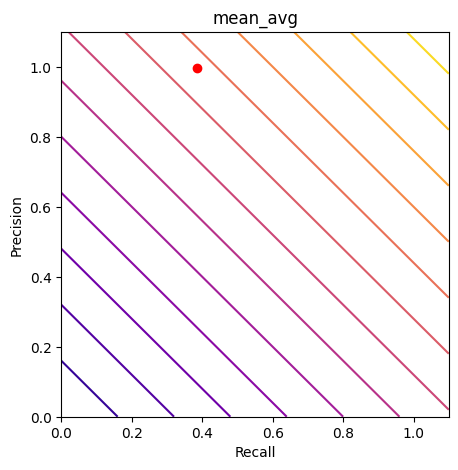

In [20]:
# Функция для отображения линий уровня
# Your code here

def level_lines(func, name):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)

    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)

    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma');

# Найдите оптимальные пороги для каждой метрики
# Your code here
MEAN = lambda x,y: (x+y)/2
m = (MEAN(precisions,recalls)).argmax()
level_lines(MEAN,"mean_avg")
plt.plot(precisions[m],recalls[m],'ro');

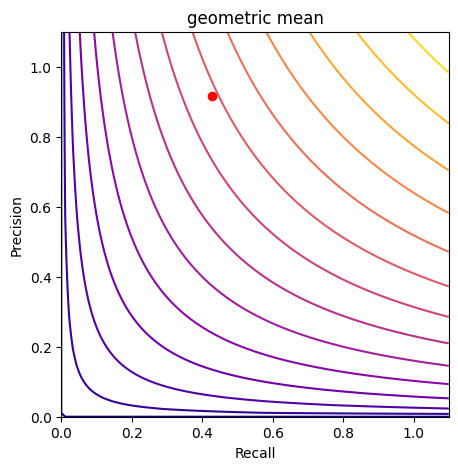

In [22]:
geo_mean = lambda x,y : np.sqrt(x*y)
g = (geo_mean(precisions,recalls)).argmax()
level_lines(geo_mean,"geometric mean")
plt.plot(precisions[g],recalls[g],'ro');


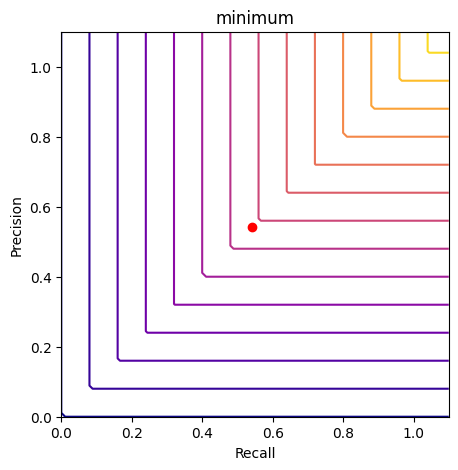

In [23]:
minimum = lambda x,y : np.minimum(x,y)
n = (minimum(precisions,recalls)).argmax()
level_lines(minimum,"minimum")
plt.plot(precisions[n],recalls[n],'ro');

**Задание 5.** Посчитайте F-меру с разными значениями $\beta^2$.
1) Найдите порог, который максимизирует F-меру при $\beta^2 = 1$.
2) Найдите порог при $\beta^2 = 0.05$.
3) Подберите $\beta^2$ так, чтобы recall > 0.8.
Для каждого случая выведите precision, recall, threshold и F-меру. Нарисуйте линии уровня и отметьте соответствующие точки на графиках.

In [15]:
# Функция для вычисления F-меры
# Your code here

f_metric = lambda p, r, b: (1 + b) * p * r / (b * p + r)
f1_idx = (f_metric(precision, recall, 1)).argmax()

print(f"Precision:\t {precision[f1_idx]}")
print(f"Recall: \t {recall[f1_idx]}")
print(f"Threshold:\t {thres[f1_idx]}")
print(f"F-score:\t {f_metric(precision[f1_idx], recall[f1_idx], 1)}")

level_lines(lambda x, y: 2 * x * y / (x + y), f"F-measure, beta = 1$")
plt.plot(recall[f1_idx], precision[f1_idx], 'ro');
# Выполните расчеты для каждого значения $\beta^2$
# Your code here

In [ ]:
### 2 пункт

b = 0.05
f_idx = (f_metric(precision, recall, b)).argmax()

print(f"Precision:\t {precisions[f_idx]}")
print(f"Recall: \t {recall[f_idx]}")
print(f"Threshold:\t {thres[f_idx]}")
print(f"F-score:\t {f_metric(precision[f_idx], recall[f_idx], b)}")

level_lines(lambda x, y: (1 + b) * x * y / (b * x + y), f"F-measure, beta = {b}$")
plt.plot(recalls[f_idx], precisions[f_idx], 'ro');

In [ ]:
### 3 пункт

b = 4
f_idx = (f_metric(precision, recall, b)).argmax()  ### Your code here

print(f"Precision:\t {precision[f_idx]}")
print(f"Recall: \t {recall[f_idx]}")
print(f"Threshold:\t {thres[f_idx]}")
print(f"F-score:\t {f_metric(precision[f_idx], recall[f_idx], b)}")

level_lines(lambda x, y: (1 + b) * x * y / (b * x + y), f"F-measure, beta = {b}$")
plt.plot(recall[f_idx], precision[f_idx], 'ro');